In [0]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [0]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

In [0]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

In [0]:
import kaggle

In [0]:
competition_name = 'carvana-image-masking-challenge'

In [0]:
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')

In [0]:
get_data(competition_name)

In [0]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [0]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [0]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [12]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


# **Visualize**

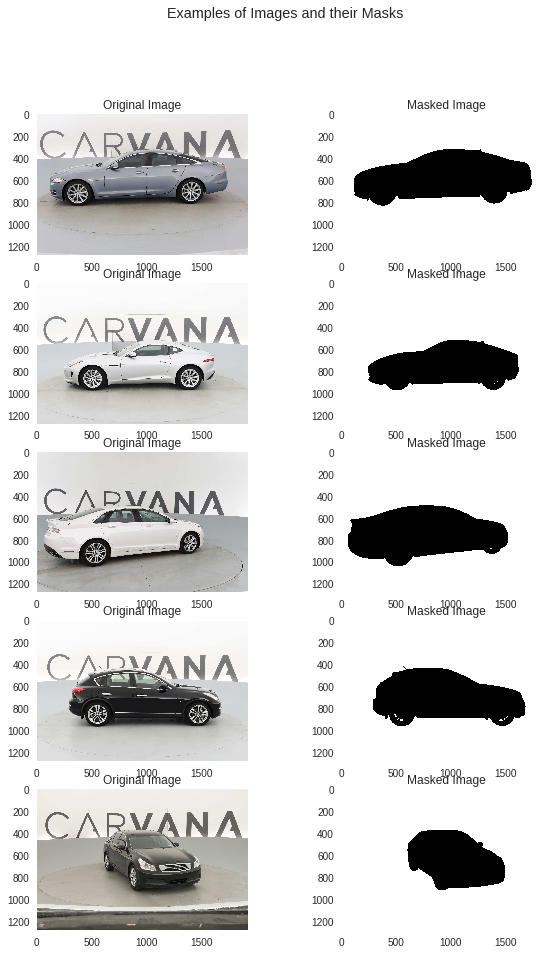

In [13]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

# Set up

In [0]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 1


# Processing each **pathname**

In [0]:
def _process_pathnames(fname, label_path):
  img_str = tf.read_file(fname)
  img = tf.image.decode_jpeg(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_gif(label_img_str)[0]
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

# Shifting the **image**

In [0]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

# Flipping the image **randomly**

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

# **Assembling our transformations into our augment function**

In [0]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
  
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.to_float(label_img) * scale
  img = tf.to_float(img) * scale 
  return img, label_img

In [0]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  dataset = dataset.repeat().batch(batch_size)
  return dataset

# **Set up train and validation datasets**

In [0]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)


In [22]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


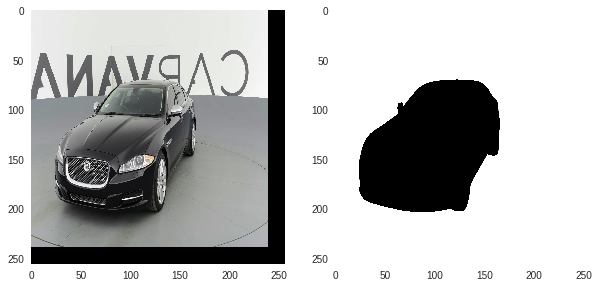

In [23]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  plt.show()

# **Build the model**

In [0]:
def FCN32_VGG(num_classes):
  inputs = layers.Input(shape=img_shape)
  
  # block 1
  conv1_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
  conv1_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(conv1_1)
  pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_2)
  
  # block 2
  conv2_1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(pool1)
  conv2_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(conv2_1)
  pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_2)
  
  # block 3
  conv3_1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(pool2)
  conv3_2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(conv3_1)
  conv3_3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(conv3_2)
  pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_3)
  
  # block 4
  conv4_1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(pool3)
  conv4_2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(conv4_1)
  conv4_3 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(conv4_2)
  pool4 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_3)
  
  # block 5
  conv5_1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(pool4)
  conv5_2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(conv5_1)
  conv5_3 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(conv5_2)
  pool5 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(conv5_3)
  
  # fully-connected layers
  fc_conv1 = layers.Conv2D(1024, (7, 7), activation='relu', padding='same', name='fc_conv1')(pool5)
  fc_drop1 = layers.Dropout(0.5, name='fc_drop1')(fc_conv1)
  fc_conv2 = layers.Conv2D(1024, (1, 1), activation='relu', padding='same', name='fc_conv2')(fc_drop1)
  fc_drop2 = layers.Dropout(0.5, name='fc_drop2')(fc_conv2)
  
  fc_conv_1x1 = layers.Conv2D(num_classes, (1, 1), padding='valid', name='fc_conv_1x1')(fc_drop2)
  pool3_1x1 = layers.Conv2D(num_classes, kernel_size=1, padding='valid', name='pool3_1x1')(pool3)
  pool4_1x1 = layers.Conv2D(num_classes, kernel_size=1, padding='valid', name='pool4_1x1')(pool4)
 
  deconv = layers.Conv2DTranspose(num_classes, kernel_size=64, strides=32, padding='same')(fc_conv_1x1)
  #deconv1 = layers.Conv2DTranspose(num_classes, kernel_size=4, strides=2, padding='same', name='deconv1')(fc_conv_1x1)
  #fuse1 = layers.add([deconv1, pool4_1x1], name='fuse1')
  #deconv2 = layers.Conv2DTranspose(num_classes, kernel_size=32, strides=16, padding='same', name='deconv2')(fuse1)
  #fuse2 = layers.add([deconv2, pool3_1x1])
  #deconv3 = layers.Conv2DTranspose(num_classes, kernel_size=16, strides=8, padding='same')(fuse2)
  
  outputs =layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(deconv)
  model = models.Model(inputs, outputs)
  return model

In [0]:
model = FCN32_VGG(num_classes=1)


# **Defining custom metrics and loss functions**

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# **Compile**

In [31]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 256, 256, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 256, 256, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 128, 128, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 64, 128)       0         
__________

In [32]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size)))
                   )

Instructions for updating:
Use tf.cast instead.
1357/1357 [==============================] - 713s 525ms/step - loss: 0.7419 - dice_loss: 0.1295 - val_loss: 0.2949 - val_dice_loss: 0.0537


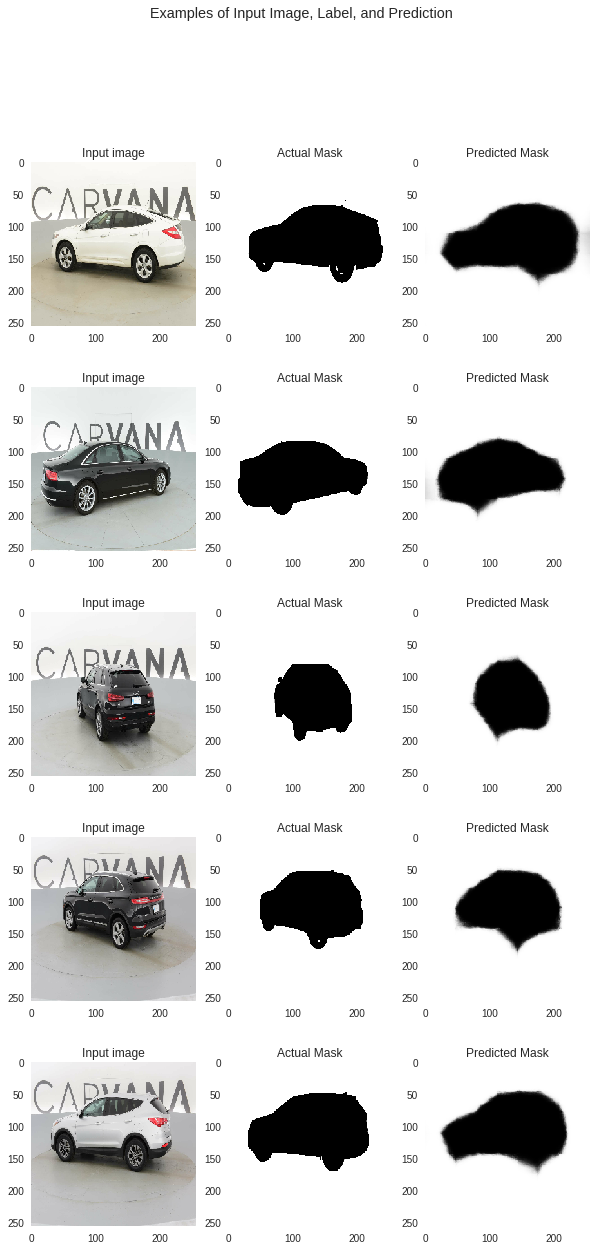

In [33]:
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0])
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()